## imports

In [3]:
import torch
import torch.nn as nn
import tensorflow as tf
import torchvision.datasets as ds
import numpy as np

## process data: MNIST 
先不要急着做改动，先充分熟悉流程，建立相对完备的流程，然后再做一些相应的改动

In [ ]:
# python 是如何进行初始化class的？

In [401]:
class Dataset():
    def __init__(self, test_val_split=0.5, normalize=True):
        """
        arg:
            test_val_split: the proportion of data_test is used for test data
        """
        self.idx = 0
        self.ds = ds
        self.ratio = test_val_split
        
        self._extract_train_test_data()
        self._test_val_split()
        if normalize:
            self._normalize()
    
    def _extract_train_test_data(self):
        data_train = self.ds.MNIST(root='/Users/ellise/Desktop/datasets/MNIST_data/', train=True, download=False)
        data_test = self.ds.MNIST(root='/Users/ellise/Desktop/datasets/MNIST_data/', train=False, download=False)
        self.X_train, self.y_train = data_train.train_data.float(), data_train.train_labels
        self.X_test, self.y_test = data_test.test_data.float(), data_test.test_labels
        self.num_instances_test = self.X_test.shape[0]
        
    def _test_val_split(self):
        """
        split test and validation set according to split ratio and total_size
        """
        split_idx = self.num_instances_test - int(self.num_instances_test * self.ratio)
        self.X_val, self.y_val = self.X_test[:split_idx], self.y_test[:split_idx]
        self.X_test, self.y_test = self.X_test[split_idx:], self.y_test[split_idx:]
        print("Train set size: {}; Test set size: {}; Validation set size: {}".format(self.X_train.shape[0],\
                                                                                     self.X_test.shape[0],\
                                                                                     self.X_val.shape[0]))
        
    def get_train_batch(self, batch_size):
        idx_start = self.idx
        idx_end = self.idx + batch_size
        self.idx += batch_size

        if(self.idx >= self.X_train.shape[0]):
            self.idx = 0
            idx_list = np.linspace(0,self.X_train.shape[0]-1,self.X_train.shape[0])
            idx_list_shuffle = np.random.shuffle(np.linspace(0,self.X_train.shape[0]-1,self.X_train.shape[0]))

            self.X_train[idx_list] = self.X_train[idx_list_shuffle]
            self.y_train[idx_list] = self.y_train[idx_list_shuffle]
        return (self.X_train[idx_start:idx_end], self.y_train[idx_start:idx_end])
    
    def _normalize(self):
        def squash(X):
            # put data into 0-1
            return (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        self.X_train = squash(self.X_train)
        print()
        self.X_test = squash(self.X_test)
        self.X_val = squash(self.X_val)
        
    def get_test_data(self):
        return (self.X_test, self.y_test)
        
    def get_validation_data(self):
        return (self.X_val, self.y_val)
    
    def get_num_of_instances_in_train(self):
        # used for return how many instances in training set in total
        return self.X_train.shape[0]
    
    def get_test_set_size(self):
        return self.X_test.shape[0]
    
    def get_val_set_size(self):
        return self.X_val.shape[0]

## define network

In [156]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        layers = [nn.Linear(in_features=784, out_features=512),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=512, out_features=128),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=128, out_features=10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.view(-1, 784))

## Define some helper functions to get results

In [157]:
def get_predictions(y_score):
    """
    arg: y_hat of scores for each class of one instance
    return: index of highest score for this instance
    """
    return y_score.detach().numpy().tolist().index(max(y_score))

def get_accuracy(pred, target):
    batch_size = len(pred)
    count = 0
    for i in range(batch_size):
        if pred[i] == target[i]:
            count += 1
    return count / batch_size

def get_acc_result(y_score, y_target):
    y_hat = [get_predictions(y) for y in y_score]
    acc = get_accuracy(pred=y_hat, target=y_target)
    return acc

## Training(0.984/0.978/0.969)

In [167]:
def Train(epochs, batch_size, learning_rate, model, opt, criterion, dataset):
    opt = opt(lr=learning_rate, params=model.parameters()) 
    criterion = criterion()
    
    num = dataset.get_num_of_instances_in_train()
    
    X_test, y_test = dataset.get_test_data()
    X_val, y_val = dataset.get_validation_data()
    # define results
    results = {}
    results["acc_train"] = []
    results["acc_test"] = []
    results["acc_validation"] = None
    
    for e in range(epochs * int(num / batch_size)):
        x_batch, y_batch = dataset.get_train_batch(batch_size=batch_size)
        y_score_train = model(x_batch)
        loss = criterion(input=y_score_train, target=y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        # get result every several number of steps
        if e % int(num/batch_size) == 0:
            cur_epoch = int(e / int(num/batch_size)) + 1
            acc_train = get_acc_result(y_score_train, y_batch)

            y_score_test = model(X_test)
            acc_test = get_acc_result(y_score_test, y_test)
            
            print("Epoch: {}; [Train/Test] : [{:.3}/{:.3}]".format(cur_epoch, acc_train, acc_test))
            results["acc_train"].append(acc_train)
            results["acc_test"].append(acc_test)
            
    y_score_val = model(X_val)
    acc_val = get_acc_result(y_score_val, y_val)
    results["acc_validation"] = acc_val
    print("******Finished! Validation acc: {:.3}******".format(acc_val))
    print("Traing/Test/Validation : {}/{}/{}".format(num, dataset.get_test_set_size(), dataset.get_val_set_size()))
    
    return results

In [215]:
dataset = Dataset(0.8)           
classifier = Classifier()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.113/0.376]
Epoch: 2; [Train/Test] : [0.906/0.894]
Epoch: 3; [Train/Test] : [0.906/0.92]
Epoch: 4; [Train/Test] : [0.914/0.934]
Epoch: 5; [Train/Test] : [0.93/0.945]
Epoch: 6; [Train/Test] : [0.957/0.95]
Epoch: 7; [Train/Test] : [0.979/0.948]
Epoch: 8; [Train/Test] : [0.969/0.956]
Epoch: 9; [Train/Test] : [0.965/0.962]
Epoch: 10; [Train/Test] : [0.953/0.962]
Epoch: 11; [Train/Test] : [0.965/0.962]
Epoch: 12; [Train/Test] : [0.953/0.964]
Epoch: 13; [Train/Test] : [0.965/0.968]
Epoch: 14; [Train/Test] : [0.961/0.966]
Epoch: 15; [Train/Test] : [0.977/0.969]
Epoch: 16; [Train/Test] : [0.969/0.968]
Epoch: 17; [Train/Test] : [0.965/0.969]
Epoch: 18; [Train/Test] : [0.926/0.967]
Epoch: 19; [Train/Test] : [0.996/0.971]
Epoch: 20; [Train/Test] : [0.965/0.971]
Epoch: 21; [Train/Test] : [0.969/0.973]
Epoch: 22; [Train/Test] : [0.973/0.973]
Epoch: 23; [Train/Test] : [0.938/0.973]
Epoch: 24; [Train/Test

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


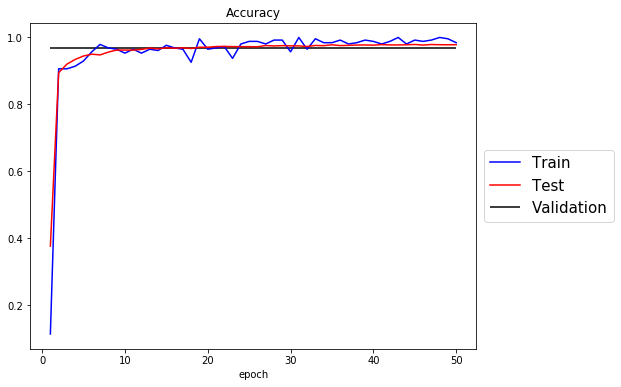

In [217]:
import matplotlib.pyplot as plt

def plot_results(results):
    plt.figure(figsize=(10,6))
    epoch = len(results["acc_train"])
    x = np.linspace(1, epoch, epoch)
    plt.plot(x, results["acc_train"], color="b")
    plt.plot(x, results["acc_test"], color="r")
    plt.hlines(results["acc_validation"], xmin=1,xmax=epoch)
    
    ax = plt.axes()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(["Train", "Test", "Validation"],loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':15})
    plt.xlabel("epoch")
    plt.title("Accuracy")
    plt.show()

plot_results(results)

## Constrast Normalization
Preprocess images to have better properties

In [173]:
class CN():
    def __init__(self, dataset):
        # the purpose of this class is to help preprocess dataset as in the arg
        self.dataset = dataset
        self._convert_train()
        self._convert_test()
        self._convert_val()
        
        
    def _contrast_transformation(self, img):
        # contrast is just std
        mean = torch.mean(img)
        contrast = torch.std(img)
        return (img - mean) / max(contrast, 1e-8) # to avoid 0
        
    def _convert_train(self):
        self.dataset.X_train = torch.Tensor([self._contrast_transformation(img).numpy() for img in self.dataset.X_train])
        
    def _convert_test(self):
        self.dataset.X_test = torch.Tensor([self._contrast_transformation(img).numpy() for img in self.dataset.X_test])
        
    def _convert_val(self):
        self.dataset.X_val = torch.Tensor([self._contrast_transformation(img).numpy() for img in self.dataset.X_val])

In [216]:
dataset = Dataset(0.8)           
CN(dataset=dataset) # only adding CN transofrmation to dataset
classifier = Classifier() # build up model
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results_contrast = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.117/0.297]
Epoch: 2; [Train/Test] : [0.918/0.914]
Epoch: 3; [Train/Test] : [0.934/0.934]
Epoch: 4; [Train/Test] : [0.93/0.945]
Epoch: 5; [Train/Test] : [0.945/0.953]
Epoch: 6; [Train/Test] : [0.957/0.961]
Epoch: 7; [Train/Test] : [0.979/0.949]
Epoch: 8; [Train/Test] : [0.984/0.962]
Epoch: 9; [Train/Test] : [0.973/0.97]
Epoch: 10; [Train/Test] : [0.965/0.97]
Epoch: 11; [Train/Test] : [0.973/0.968]
Epoch: 12; [Train/Test] : [0.965/0.97]
Epoch: 13; [Train/Test] : [0.969/0.973]
Epoch: 14; [Train/Test] : [0.977/0.974]
Epoch: 15; [Train/Test] : [0.992/0.977]
Epoch: 16; [Train/Test] : [0.984/0.977]
Epoch: 17; [Train/Test] : [0.98/0.974]
Epoch: 18; [Train/Test] : [0.961/0.974]
Epoch: 19; [Train/Test] : [0.996/0.978]
Epoch: 20; [Train/Test] : [0.969/0.978]
Epoch: 21; [Train/Test] : [0.977/0.98]
Epoch: 22; [Train/Test] : [0.984/0.98]
Epoch: 23; [Train/Test] : [0.984/0.978]
Epoch: 24; [Train/Test] : 

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


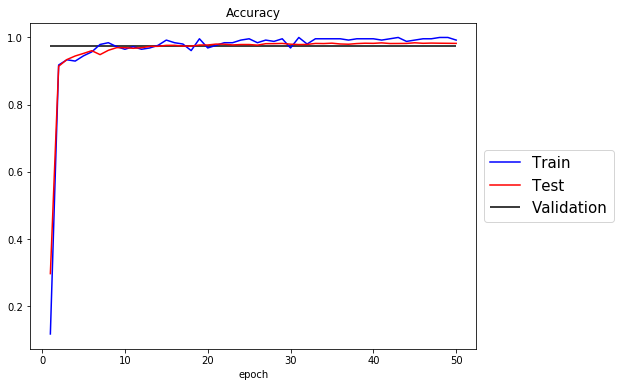

In [218]:
plot_results(results_contrast)

## Train Auto-Encoder To Get Latent Code And Train Classifier On Latent Code

### Define A Auto-Encoder Network and Train it

In [250]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=512))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=512, out_features=256))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=256, out_features=10))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x.view(-1, 784))
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=10, out_features=256))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=256, out_features=512))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=512, out_features=784))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z) 

In [289]:
def Train_AE(epochs, batch_size, learning_rate, encoder, decoder, opt, criterion, dataset):
    param = list(encoder.parameters()) + list(decoder.parameters())
    opt = opt(lr=learning_rate, params=param) 
    criterion = criterion()
    
    num = dataset.get_num_of_instances_in_train()
    
    X_test, y_test = dataset.get_test_data()
    
    for e in range(epochs * int(num / batch_size)):
        x_batch, y_batch = dataset.get_train_batch(batch_size=batch_size)
        x_batch_hat = decoder(encoder(x_batch))
        loss = criterion(input=x_batch_hat, target=x_batch.view(-1, 784))
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        # get result every several number of steps
        if e % int(num/batch_size) == 0:
            cur_epoch = int(e / int(num/batch_size)) + 1
            print("Epoch: {}; [Loss] : [{}]".format(cur_epoch, loss))
            
    X_test_hat = decoder(encoder(X_test))
    loss_test = criterion(input=X_test_hat, target=X_test.view(-1,784))
    print("Test Loss: {}".format(loss_test))

In [290]:
dataset = Dataset(test_val_split=0.8,normalize=True) # normalize data to 0,1
encoder = Encoder()
decoder = Decoder()
opt = torch.optim.Adam
criterion = nn.MSELoss
Train_AE(epochs=50, batch_size=256, learning_rate=5e-3, encoder=encoder, decoder=decoder,opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Loss] : [0.23093105852603912]
Epoch: 2; [Loss] : [0.06134575605392456]
Epoch: 3; [Loss] : [0.05958554893732071]
Epoch: 4; [Loss] : [0.04725509136915207]
Epoch: 5; [Loss] : [0.03722343593835831]
Epoch: 6; [Loss] : [0.03157776966691017]
Epoch: 7; [Loss] : [0.0318424366414547]
Epoch: 8; [Loss] : [0.027654007077217102]
Epoch: 9; [Loss] : [0.02906573936343193]
Epoch: 10; [Loss] : [0.025201529264450073]
Epoch: 11; [Loss] : [0.025976885110139847]
Epoch: 12; [Loss] : [0.024514175951480865]
Epoch: 13; [Loss] : [0.021953213959932327]
Epoch: 14; [Loss] : [0.023697666823863983]
Epoch: 15; [Loss] : [0.01899244263768196]
Epoch: 16; [Loss] : [0.0193423293530941]
Epoch: 17; [Loss] : [0.019459886476397514]
Epoch: 18; [Loss] : [0.02163897082209587]
Epoch: 19; [Loss] : [0.017230259254574776]
Epoch: 20; [Loss] : [0.01932567171752453]
Epoch: 21; [Loss] : [0.018554581329226494]
Epoch: 22; [Loss] : [0.017633626237511635]
Epoch: 

### Take a look at the reconstructed images

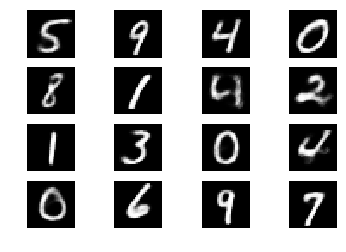

In [287]:
x_batch, _ = dataset.get_train_batch(batch_size=16)
x_reconst = decoder(encoder(x_batch.view(-1, 784)))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_reconst[i].view(28,28).detach(), cmap='gray')
    plt.axis('off')


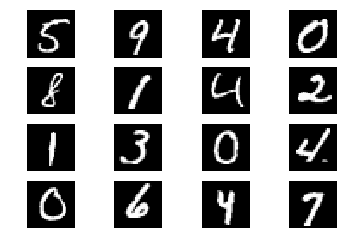

In [288]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_batch[i].detach(), cmap='gray')
    plt.axis('off')

### Using Latent Code To Train Classifier

In [317]:
class Classifier_AE(nn.Module):
    def __init__(self):
        super(Classifier_AE,self).__init__()
        layers = [nn.Linear(in_features=10, out_features=512),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=512, out_features=128),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=128, out_features=10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [308]:
dataset = Dataset(test_val_split=0.8,normalize=True) # normalize data to 0,1
dataset.X_train = encoder(dataset.X_train).detach()
dataset.X_test = encoder(dataset.X_test).detach()
dataset.X_val = encoder(dataset.X_val).detach()
classifier_ae = Classifier_AE()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
result_ae = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier_ae, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.0859/0.494]
Epoch: 2; [Train/Test] : [0.918/0.928]
Epoch: 3; [Train/Test] : [0.906/0.937]
Epoch: 4; [Train/Test] : [0.93/0.942]
Epoch: 5; [Train/Test] : [0.941/0.947]
Epoch: 6; [Train/Test] : [0.965/0.949]
Epoch: 7; [Train/Test] : [0.969/0.943]
Epoch: 8; [Train/Test] : [0.961/0.95]
Epoch: 9; [Train/Test] : [0.934/0.955]
Epoch: 10; [Train/Test] : [0.957/0.954]
Epoch: 11; [Train/Test] : [0.934/0.954]
Epoch: 12; [Train/Test] : [0.941/0.955]
Epoch: 13; [Train/Test] : [0.949/0.956]
Epoch: 14; [Train/Test] : [0.949/0.956]
Epoch: 15; [Train/Test] : [0.953/0.957]
Epoch: 16; [Train/Test] : [0.961/0.957]
Epoch: 17; [Train/Test] : [0.957/0.957]
Epoch: 18; [Train/Test] : [0.906/0.957]
Epoch: 19; [Train/Test] : [0.988/0.958]
Epoch: 20; [Train/Test] : [0.945/0.957]
Epoch: 21; [Train/Test] : [0.949/0.959]
Epoch: 22; [Train/Test] : [0.941/0.958]
Epoch: 23; [Train/Test] : [0.945/0.957]
Epoch: 24; [Train/Te

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


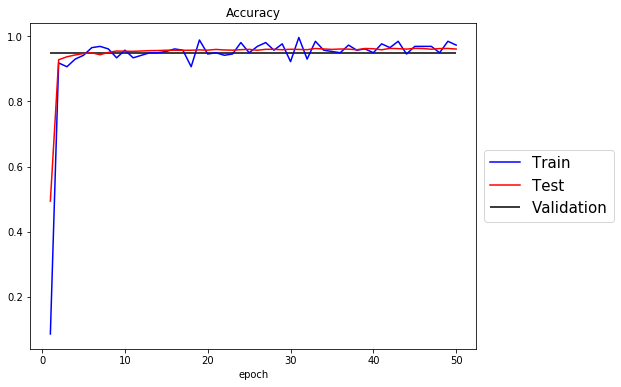

In [309]:
plot_results(result_ae)

## Change layer units or activation functions 

In [313]:
class Classifier_sigmoid(nn.Module):
    def __init__(self):
        super(Classifier_sigmoid,self).__init__()
        layers = [nn.Linear(in_features=784, out_features=512),
                  nn.Sigmoid(),
                  nn.Linear(in_features=512, out_features=128),
                  nn.Sigmoid(),
                  nn.Linear(in_features=128, out_features=10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.view(-1, 784))

In [315]:
dataset = Dataset(0.8)           
classifier_sigmoid = Classifier_sigmoid()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results_sigmoid = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier_sigmoid, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.102/0.113]
Epoch: 2; [Train/Test] : [0.836/0.837]
Epoch: 3; [Train/Test] : [0.844/0.885]
Epoch: 4; [Train/Test] : [0.852/0.898]
Epoch: 5; [Train/Test] : [0.883/0.908]
Epoch: 6; [Train/Test] : [0.902/0.915]
Epoch: 7; [Train/Test] : [0.917/0.914]
Epoch: 8; [Train/Test] : [0.922/0.92]
Epoch: 9; [Train/Test] : [0.945/0.925]
Epoch: 10; [Train/Test] : [0.871/0.925]
Epoch: 11; [Train/Test] : [0.926/0.927]
Epoch: 12; [Train/Test] : [0.922/0.931]
Epoch: 13; [Train/Test] : [0.953/0.931]
Epoch: 14; [Train/Test] : [0.941/0.932]
Epoch: 15; [Train/Test] : [0.953/0.936]
Epoch: 16; [Train/Test] : [0.949/0.935]
Epoch: 17; [Train/Test] : [0.938/0.938]
Epoch: 18; [Train/Test] : [0.867/0.937]
Epoch: 19; [Train/Test] : [0.969/0.939]
Epoch: 20; [Train/Test] : [0.906/0.94]
Epoch: 21; [Train/Test] : [0.953/0.94]
Epoch: 22; [Train/Test] : [0.934/0.943]
Epoch: 23; [Train/Test] : [0.902/0.942]
Epoch: 24; [Train/Test

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


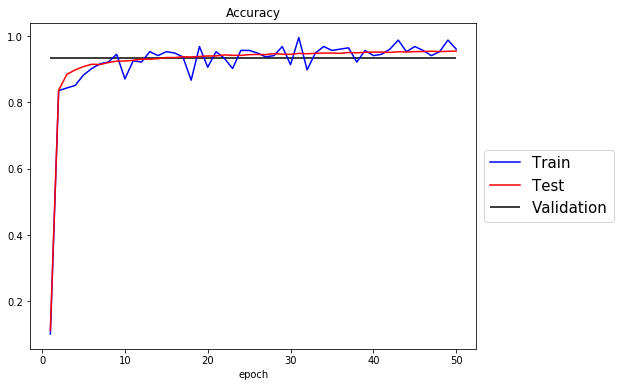

In [316]:
plot_results(results_sigmoid)

## Adding Batch Normalization layer(1/0.985/0.978)

In [329]:
class Classifier_BN(nn.Module):
    def __init__(self):
        super(Classifier_BN,self).__init__()
        layers = [nn.Linear(in_features=784, out_features=512),
                  nn.BatchNorm1d(num_features=512),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=512, out_features=128),
                  nn.BatchNorm1d(num_features=128),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=128, out_features=10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.view(-1, 784))

In [330]:
dataset = Dataset(0.8)           
classifier_BN = Classifier_BN()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results_sigmoid = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier_BN, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.113/0.666]
Epoch: 2; [Train/Test] : [0.938/0.942]
Epoch: 3; [Train/Test] : [0.941/0.957]
Epoch: 4; [Train/Test] : [0.945/0.966]
Epoch: 5; [Train/Test] : [0.965/0.971]
Epoch: 6; [Train/Test] : [0.98/0.971]
Epoch: 7; [Train/Test] : [0.979/0.975]
Epoch: 8; [Train/Test] : [0.98/0.978]
Epoch: 9; [Train/Test] : [0.984/0.978]
Epoch: 10; [Train/Test] : [0.977/0.982]
Epoch: 11; [Train/Test] : [0.984/0.981]
Epoch: 12; [Train/Test] : [0.961/0.98]
Epoch: 13; [Train/Test] : [0.977/0.98]
Epoch: 14; [Train/Test] : [0.988/0.981]
Epoch: 15; [Train/Test] : [0.996/0.982]
Epoch: 16; [Train/Test] : [1.0/0.984]
Epoch: 17; [Train/Test] : [0.996/0.984]
Epoch: 18; [Train/Test] : [0.992/0.981]
Epoch: 19; [Train/Test] : [1.0/0.982]
Epoch: 20; [Train/Test] : [0.996/0.982]
Epoch: 21; [Train/Test] : [1.0/0.984]
Epoch: 22; [Train/Test] : [1.0/0.985]
Epoch: 23; [Train/Test] : [0.988/0.984]
Epoch: 24; [Train/Test] : [0.99

## Adding more layers hence more parameters(1/0.981/0.971)

In [332]:
class Classifier_adding_layers(nn.Module):
    def __init__(self):
        super(Classifier_adding_layers,self).__init__()
        layers = [nn.Linear(in_features=784, out_features=512),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=512, out_features=512),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=512, out_features=256),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=256, out_features=128),
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=128, out_features=10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.view(-1, 784))

In [335]:
dataset = Dataset(0.8)           
classifier_add = Classifier_adding_layers()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results_add = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier_add, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.102/0.1]
Epoch: 2; [Train/Test] : [0.852/0.85]
Epoch: 3; [Train/Test] : [0.891/0.919]
Epoch: 4; [Train/Test] : [0.895/0.931]
Epoch: 5; [Train/Test] : [0.941/0.942]
Epoch: 6; [Train/Test] : [0.949/0.957]
Epoch: 7; [Train/Test] : [0.958/0.949]
Epoch: 8; [Train/Test] : [0.973/0.965]
Epoch: 9; [Train/Test] : [0.961/0.969]
Epoch: 10; [Train/Test] : [0.957/0.971]
Epoch: 11; [Train/Test] : [0.973/0.968]
Epoch: 12; [Train/Test] : [0.949/0.967]
Epoch: 13; [Train/Test] : [0.965/0.974]
Epoch: 14; [Train/Test] : [0.969/0.973]
Epoch: 15; [Train/Test] : [0.988/0.976]
Epoch: 16; [Train/Test] : [0.988/0.977]
Epoch: 17; [Train/Test] : [0.988/0.974]
Epoch: 18; [Train/Test] : [0.957/0.972]
Epoch: 19; [Train/Test] : [1.0/0.978]
Epoch: 20; [Train/Test] : [0.98/0.976]
Epoch: 21; [Train/Test] : [0.977/0.979]
Epoch: 22; [Train/Test] : [0.98/0.98]
Epoch: 23; [Train/Test] : [0.965/0.975]
Epoch: 24; [Train/Test] : [

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


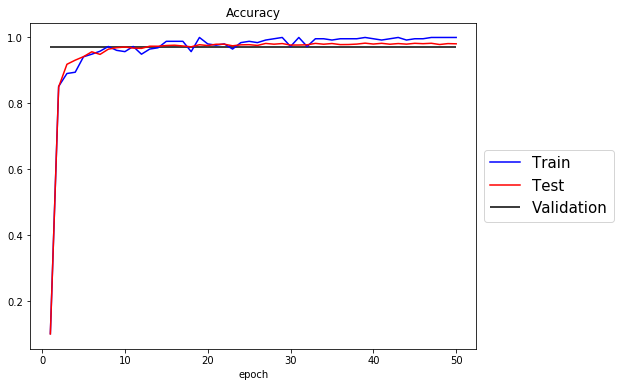

In [336]:
plot_results(results_add)

## Trying SGD optimizer

In [338]:
dataset = Dataset(0.8)           
classifier_SGD = Classifier()
opt = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss
results_sgd = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier_SGD, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.121/0.105]
Epoch: 2; [Train/Test] : [0.191/0.185]
Epoch: 3; [Train/Test] : [0.227/0.226]
Epoch: 4; [Train/Test] : [0.215/0.28]
Epoch: 5; [Train/Test] : [0.402/0.373]
Epoch: 6; [Train/Test] : [0.5/0.424]
Epoch: 7; [Train/Test] : [0.333/0.479]
Epoch: 8; [Train/Test] : [0.629/0.544]
Epoch: 9; [Train/Test] : [0.609/0.573]
Epoch: 10; [Train/Test] : [0.508/0.606]
Epoch: 11; [Train/Test] : [0.602/0.635]
Epoch: 12; [Train/Test] : [0.59/0.673]
Epoch: 13; [Train/Test] : [0.758/0.705]
Epoch: 14; [Train/Test] : [0.742/0.725]
Epoch: 15; [Train/Test] : [0.727/0.734]
Epoch: 16; [Train/Test] : [0.707/0.766]
Epoch: 17; [Train/Test] : [0.727/0.78]
Epoch: 18; [Train/Test] : [0.684/0.793]
Epoch: 19; [Train/Test] : [0.855/0.804]
Epoch: 20; [Train/Test] : [0.77/0.807]
Epoch: 21; [Train/Test] : [0.812/0.815]
Epoch: 22; [Train/Test] : [0.832/0.826]
Epoch: 23; [Train/Test] : [0.777/0.83]
Epoch: 24; [Train/Test] : 

/Users/ellise/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


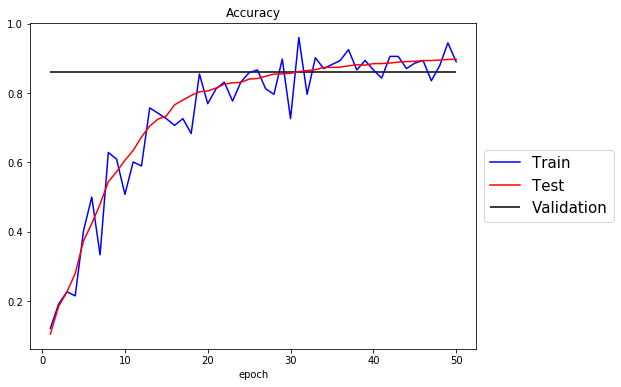

In [339]:
plot_results(results_sgd) # 收敛更慢， 最终准确率也低一些，效果没有ADAM好

In [342]:
# 加大learning rate， 考虑收敛可能比较慢
dataset = Dataset(0.8)           
classifier_SGD = Classifier()
opt = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss
results_sgd = Train(epochs=50, batch_size=256, learning_rate=5e-1, model=classifier_SGD, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.102/0.115]
Epoch: 2; [Train/Test] : [0.84/0.766]
Epoch: 3; [Train/Test] : [0.84/0.868]
Epoch: 4; [Train/Test] : [0.848/0.901]
Epoch: 5; [Train/Test] : [0.883/0.919]
Epoch: 6; [Train/Test] : [0.926/0.94]
Epoch: 7; [Train/Test] : [0.958/0.933]
Epoch: 8; [Train/Test] : [0.965/0.953]
Epoch: 9; [Train/Test] : [0.961/0.96]
Epoch: 10; [Train/Test] : [0.926/0.959]
Epoch: 11; [Train/Test] : [0.961/0.963]
Epoch: 12; [Train/Test] : [0.945/0.958]
Epoch: 13; [Train/Test] : [0.961/0.967]
Epoch: 14; [Train/Test] : [0.973/0.968]
Epoch: 15; [Train/Test] : [0.973/0.972]
Epoch: 16; [Train/Test] : [0.977/0.971]
Epoch: 17; [Train/Test] : [0.973/0.972]
Epoch: 18; [Train/Test] : [0.938/0.97]
Epoch: 19; [Train/Test] : [1.0/0.975]
Epoch: 20; [Train/Test] : [0.98/0.975]
Epoch: 21; [Train/Test] : [0.973/0.977]
Epoch: 22; [Train/Test] : [0.977/0.976]
Epoch: 23; [Train/Test] : [0.957/0.963]
Epoch: 24; [Train/Test] : [

SGD加大lr效果好

In [343]:
dataset = Dataset(0.8)           
classifier_SGD = Classifier()
opt = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss
results_sgd = Train(epochs=50, batch_size=256, learning_rate=5e-1, model=classifier_SGD, opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000
Epoch: 1; [Train/Test] : [0.0938/0.101]
Epoch: 2; [Train/Test] : [0.109/0.103]
Epoch: 3; [Train/Test] : [0.109/0.0956]
Epoch: 4; [Train/Test] : [0.0859/0.101]
Epoch: 5; [Train/Test] : [0.129/0.113]
Epoch: 6; [Train/Test] : [0.0938/0.1]
Epoch: 7; [Train/Test] : [0.115/0.1]
Epoch: 8; [Train/Test] : [0.0977/0.1]
Epoch: 9; [Train/Test] : [0.113/0.113]
Epoch: 10; [Train/Test] : [0.082/0.101]
Epoch: 11; [Train/Test] : [0.117/0.113]
Epoch: 12; [Train/Test] : [0.109/0.1]
Epoch: 13; [Train/Test] : [0.0938/0.1]
Epoch: 14; [Train/Test] : [0.109/0.103]
Epoch: 15; [Train/Test] : [0.0977/0.113]
Epoch: 16; [Train/Test] : [0.117/0.113]
Epoch: 17; [Train/Test] : [0.109/0.113]
Epoch: 18; [Train/Test] : [0.0586/0.1]
Epoch: 19; [Train/Test] : [0.0938/0.1]
Epoch: 20; [Train/Test] : [0.109/0.103]
Epoch: 21; [Train/Test] : [0.0977/0.113]
Epoch: 22; [Train/Test] : [0.113/0.113]
Epoch: 23; [Train/Test] : [0.102/0.113]
Epoch: 24; [Train/Test]

Adam：同样lr训不出来，可能所支持lr比SGD小

## 旋转

In [403]:
from skimage.transform import rotate
def rotate_(img):
    angle = np.random.randint(0, 361)
    return rotate(img, angle)

dataset = Dataset(0.8)
dataset.X_train = torch.Tensor(np.append(dataset.X_train,np.array([rotate_(img) for img in dataset.X_train]), axis=0))
dataset.y_train = torch.Tensor(np.append(dataset.y_train,dataset.y_train,axis=0)).long()

Train set size: 60000; Test set size: 8000; Validation set size: 2000



In [404]:
print(dataset.X_train.size(), dataset.y_train.shape)

torch.Size([120000, 28, 28]) torch.Size([120000])


In [405]:
classifier = Classifier()
opt = torch.optim.Adagrad
criterion = torch.nn.CrossEntropyLoss
results_rotate = Train(epochs=50, batch_size=256, learning_rate=1e-2, model=classifier, opt=opt, criterion=criterion, dataset=dataset)

Epoch: 1; [Train/Test] : [0.133/0.359]
Epoch: 2; [Train/Test] : [0.885/0.886]
Epoch: 3; [Train/Test] : [0.871/0.922]
Epoch: 4; [Train/Test] : [0.906/0.933]
Epoch: 5; [Train/Test] : [0.965/0.954]
Epoch: 6; [Train/Test] : [0.973/0.959]
Epoch: 7; [Train/Test] : [0.973/0.964]
Epoch: 8; [Train/Test] : [0.977/0.965]
Epoch: 9; [Train/Test] : [0.965/0.967]
Epoch: 10; [Train/Test] : [0.977/0.967]
Epoch: 11; [Train/Test] : [0.93/0.969]
Epoch: 12; [Train/Test] : [0.973/0.968]
Epoch: 13; [Train/Test] : [0.973/0.969]
Epoch: 14; [Train/Test] : [0.98/0.968]
Epoch: 15; [Train/Test] : [0.973/0.969]
Epoch: 16; [Train/Test] : [0.957/0.97]
Epoch: 17; [Train/Test] : [0.977/0.97]
Epoch: 18; [Train/Test] : [0.965/0.97]
Epoch: 19; [Train/Test] : [0.992/0.97]
Epoch: 20; [Train/Test] : [0.977/0.971]
Epoch: 21; [Train/Test] : [0.98/0.971]
Epoch: 22; [Train/Test] : [0.988/0.972]
Epoch: 23; [Train/Test] : [0.996/0.971]
Epoch: 24; [Train/Test] : [0.996/0.972]
Epoch: 25; [Train/Test] : [0.977/0.971]
Epoch: 26; [Trai

  可能因为test和validation中没有明显的旋转，所以将train中旋转做新的数据效果并不明显。

In [232]:
class Test():
    # 没有constructor也可以
    def __init__(self): # 第一个参数就是实例
        self.data = 1
    
    @staticmethod
    def static_method(): # staticmethod 是否能从实例中获取数据？不能· staticmethod根本没有self
        print("I'm static method!")
        
    @classmethod
    def class_method(self): # 类方法必须给self; bound method
        print("I'm class method!")
        
t = Test()
t.static_method()
Test.static_method()
t.class_method()
t.static_method

I'm static method!
I'm static method!
I'm class method!


<function __main__.Test.static_method()>

In [406]:
t = Test()
print(callable(t))
class Callable():
    def __call__(self):
        print("this is callable!")
        
t = Callable() 
# after implementing __call__ function for class, the instance should become callable
print(callable(t))
t()

False
True
this is callable!


In [414]:
from functools import partial

def mul(a,v):
    return a*v

# give a function as arg and its left most element and returns another function of remaining args
dbl = partial(mul, 2) # 2 will replace a 
# now dbl is a new function that muls arg by 2
dbl(3)
# what if there are 3 args?
def mul_2(a,b,c):
    return a*b+c

dbl_2 = partial(mul_2, 3)
dbl_2(2,1) # 3 * 2 + 1

7

In [445]:
# pytorch autograd: defined by code; set require_grad=True, and use backward() to compute all gradients
# detach() to stop tracking history; so gradients are stored as regarding to each variable of operations
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [447]:
y = 2*x + 2
print(y)

tensor([[4., 4.],
        [4., 4.]], grad_fn=<AddBackward0>)


In [448]:
torch.sum(y).backward()

In [449]:
x.grad

tensor([[2., 2.],
        [2., 2.]])

In [ ]:
# step: can be called once backward() has been called for loss on parameters to be optimized
# need to clear gradient once finishing each step

## Using GAN to generate extra samples

In [567]:
# 首先在数据集上训练一个GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=100, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=784))
        layers.append(nn.Sigmoid()) # Tanh不太行，可能和Linear而不是Conv有关
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x.view(x.shape[0], -1))

In [573]:
G = Generator()
D = Discriminator()
opt_G = torch.optim.Adam(lr=1e-3,params=G.parameters())
opt_D = torch.optim.Adam(lr=1e-3,params=D.parameters())

dataset = Dataset(0.8, True)
# change training set to [-1,1]
#dataset.X_train = (dataset.X_train - 0.5) * 2
epochs = 50
num = dataset.get_num_of_instances_in_train()
batch_size = 256
for e in range(epochs * int(num / batch_size)):    
    for i in range(1):
        x_real, _ = dataset.get_train_batch(batch_size)
        z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
        x_fake = G(z)

        D_real = D(x_real)
        D_fake = D(x_fake)

        # loss_D = - torch.mean(torch.log(D_real) + torch.log(1-D_fake))
        loss_D = nn.functional.binary_cross_entropy(input=D_real, target=torch.ones_like(D_real))
        loss_D += nn.functional.binary_cross_entropy(input=D_fake, target=torch.zeros_like(D_fake))

        # update D
        loss_D.backward()
        opt_D.step()
        opt_D.zero_grad()
        opt_G.zero_grad()
    
    z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
    x_fake_ = G(z)
    D_fake_ = D(x_fake_)
    #loss_G = - torch.mean(torch.log(D_fake))
    loss_G = nn.functional.binary_cross_entropy(input=D_fake_, target=torch.ones_like(D_fake_))
    
    # update G
    loss_G.backward()
    opt_G.step()
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    if e % int(num/batch_size) == 0:
        print("Epoch:{};Loss_D:{};Loss_G:{}".format(int(e / int(num/batch_size)), loss_D, loss_G))

Train set size: 60000; Test set size: 8000; Validation set size: 2000

Epoch:0;Loss_D:1.3388092517852783;Loss_G:1.1775656938552856
Epoch:1;Loss_D:0.08554774522781372;Loss_G:4.799373626708984
Epoch:2;Loss_D:0.030910350382328033;Loss_G:5.386926174163818
Epoch:3;Loss_D:0.02966383844614029;Loss_G:6.54968786239624
Epoch:4;Loss_D:0.15499959886074066;Loss_G:4.041447162628174
Epoch:5;Loss_D:0.07569213211536407;Loss_G:5.07236909866333
Epoch:6;Loss_D:0.09024043381214142;Loss_G:5.368954658508301
Epoch:7;Loss_D:0.06082437187433243;Loss_G:4.373559951782227
Epoch:8;Loss_D:0.04115014150738716;Loss_G:4.919280529022217
Epoch:9;Loss_D:0.09557738900184631;Loss_G:5.704147815704346
Epoch:10;Loss_D:0.10674259066581726;Loss_G:7.109254837036133
Epoch:11;Loss_D:0.05613766610622406;Loss_G:6.6205549240112305
Epoch:12;Loss_D:0.12873752415180206;Loss_G:5.229218006134033
Epoch:13;Loss_D:0.17186138033866882;Loss_G:5.7808709144592285
Epoch:14;Loss_D:0.17968766391277313;Loss_G:5.725295066833496
Epoch:15;Loss_D:0.13300

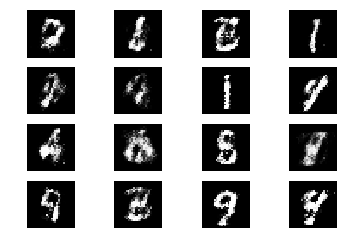

In [577]:
# generate some images and plot
z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
x_fake = G(z).view(x_real.shape[0], 28, 28)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_fake[i].detach(), cmap='gray')
    plt.axis('off')

## GAN训练总结：1. opt无论D还是G step后，均要reset；2. G最后一层激活函数 3. GAN train多久为好（多train还是合适？）4. 质量很低，若要尝试作为训练集，需要用更大的网络

# TODO: 几个可以做的目标： 1。data 增强（旋转，done） 2. 模型 更改结构或者activation（层）(done， BatchNormalization效果好) 3. 优化器（done） 5. AE用隐码进行训练(没有明显效果) 6. GAN生成额外样本进行训练(可以尝试，这样会扩充训练集)

# 结论：
加layers，加BN，进行Contrast Normalization， 均有一定效果，其中， 加BN的效果最好；用AE code进行训练也应该有效果，可能是AE训得不够好； GAN也存在需要训的足够好才可能起到预期效果的问题。